In [3]:
import sys, os
sys.path.insert(0,'..')
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
%load_ext autoreload
%autoreload 2

In [18]:
import torch
from models import LSTM, NN
from optim import AdamHD
import pandas as pd
import datetime
import numpy as np
from losses import MSE, gaussian_loss
import matplotlib.pyplot as plt

In [6]:
def convert_timestamp(timestamps):
    return [datetime.datetime.strptime(timestamp,'%Y-%m-%d') for timestamp in timestamps.values]

def normalise(data, return_stats=False):
    mean, std = np.mean(data), np.std(data)
    if not return_stats:
        return (data-mean)/std
    return (data-mean)/std, mean, std

In [7]:
avocado_data = pd.read_csv("data/avocado.csv", index_col=0)
avocado_data["Date"] = convert_timestamp(avocado_data["Date"])
avocado_data = avocado_data.sort_values("Date")
avocado_data

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
51,2015-01-04,1.75,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.00,organic,2015,Southeast
51,2015-01-04,1.49,17723.17,1189.35,15628.27,0.00,905.55,905.55,0.00,0.00,organic,2015,Chicago
51,2015-01-04,1.68,2896.72,161.68,206.96,0.00,2528.08,2528.08,0.00,0.00,organic,2015,HarrisburgScranton
51,2015-01-04,1.52,54956.80,3013.04,35456.88,1561.70,14925.18,11264.80,3660.38,0.00,conventional,2015,Pittsburgh
51,2015-01-04,1.64,1505.12,1.27,1129.50,0.00,374.35,186.67,187.68,0.00,organic,2015,Boise
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2018-03-25,1.36,908202.13,142681.06,463136.28,174975.75,127409.04,103579.41,22467.04,1362.59,conventional,2018,Chicago
0,2018-03-25,0.70,9010588.32,3999735.71,966589.50,30130.82,4014132.29,3398569.92,546409.74,69152.63,conventional,2018,SouthCentral
0,2018-03-25,1.42,163496.70,29253.30,5080.04,0.00,129163.36,109052.26,20111.10,0.00,organic,2018,SouthCentral
0,2018-03-25,1.70,190257.38,29644.09,70982.10,0.00,89631.19,89424.11,207.08,0.00,organic,2018,California


In [6]:
avocado_data.columns

Index(['Date', 'AveragePrice', 'Total Volume', '4046', '4225', '4770',
       'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'year',
       'region'],
      dtype='object')

In [8]:
unique_regions = avocado_data["region"].unique()
train_regions = unique_regions[:36]
test_regions = unique_regions[36:]
unique_regions

array(['Southeast', 'Chicago', 'HarrisburgScranton', 'Pittsburgh',
       'Boise', 'WestTexNewMexico', 'LosAngeles', 'LasVegas', 'Atlanta',
       'DallasFtWorth', 'MiamiFtLauderdale', 'Plains', 'StLouis',
       'Syracuse', 'Midsouth', 'Sacramento', 'Boston', 'Charlotte',
       'Spokane', 'Albany', 'Houston', 'SouthCarolina', 'SanFrancisco',
       'TotalUS', 'RaleighGreensboro', 'BuffaloRochester',
       'NorthernNewEngland', 'GrandRapids', 'Denver', 'SanDiego',
       'BaltimoreWashington', 'Roanoke', 'RichmondNorfolk', 'Northeast',
       'SouthCentral', 'GreatLakes', 'Louisville', 'Seattle',
       'CincinnatiDayton', 'NewYork', 'NewOrleansMobile', 'Indianapolis',
       'Jacksonville', 'Columbus', 'Detroit', 'Philadelphia',
       'PhoenixTucson', 'Nashville', 'Portland', 'HartfordSpringfield',
       'Tampa', 'Orlando', 'West', 'California'], dtype=object)

# Data pre-processing

In [9]:
region_stats = dict()

def create_dataset(regions):
    x_out = None
    y_out = None

    for region in regions:
        d1 = avocado_data.loc[(avocado_data["region"] == region) & (avocado_data["type"]=="conventional")]
        time_stamps, avg_price, volume = d1["Date"], d1["AveragePrice"].values, d1["Total Volume"].values
        price, mean_price, std_price = normalise(avg_price, True)
        volume,  mean_vol, std_vol = normalise(volume, True)
        price = torch.tensor(price, dtype=torch.float32).view(-1, 1)
        volume = torch.tensor(volume, dtype=torch.float32).view(-1, 1)
        region_stats[region] = {"mean_price": mean_price, "mean_vol": mean_vol, "std_price": std_price, "std_vol": std_vol}
        if x_out is None:
            x_out = volume
            y_out = price
        else:
            x_out = torch.cat((x_out, volume), dim=1)
            y_out = torch.cat((y_out, price), dim=1)

    return x_out.unsqueeze(-1), y_out.unsqueeze(-1)

x_train, y_train = create_dataset(train_regions)
x_test, y_test = create_dataset(test_regions)

In [10]:
x_train.shape  # Sequence length, batch size, dim(x)

torch.Size([169, 36, 1])

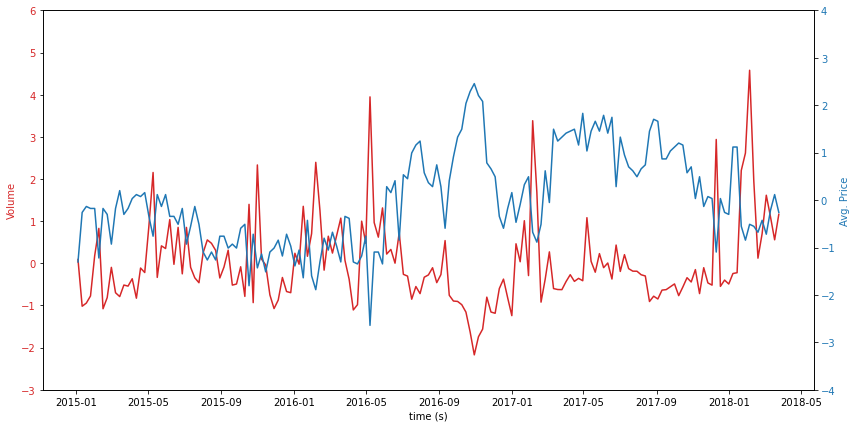

In [11]:
region = "NewYork"

d1 = avocado_data.loc[(avocado_data["region"] == region) & (avocado_data["type"]=="conventional")]
time_stamps, avg_price, volume = d1["Date"], d1["AveragePrice"], d1["Total Volume"]


avg_price = normalise(avg_price, False)
volume = normalise(volume, False)

fig, ax1 = plt.subplots(figsize=(12,6))

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Volume', color=color)
ax1.plot(time_stamps, volume, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Avg. Price', color=color)  # we already handled the x-label with ax1
ax2.plot(time_stamps, avg_price, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.set_ylim(-3, 6)
ax2.set_ylim(-4, 4)
plt.show()

In [88]:
hidden_dim = 50
sequence_length, batch_dim, x_dim = x_train.size()
lstm = LSTM(x_dim, hidden_dim, 2)
optimiser = AdamHD(lstm.parameters(), alpha_lr=1e-8)
epochs = 500
output_dim = y_train.size(-1)
gaussian = True

def lstm_prediction(x, gaussian=False):
    sequence_length, batch_dim, x_dim = x.size()
    h = torch.zeros((batch_dim, hidden_dim))
    c = torch.zeros((batch_dim, hidden_dim))
    y_preds = torch.zeros((sequence_length, batch_dim, output_dim))
    
    if gaussian:
        y_log_vars = torch.zeros((sequence_length, batch_dim, output_dim))

    for i, x_t in enumerate(x):
        h, c, y = lstm(x_t, h, c)
        if gaussian:
            y_preds[i] = y[:, :output_dim]
            y_log_vars[i] = y[:, output_dim:]
        else:
            y_preds[i] = y

    if gaussian:
        return y_preds, y_log_vars
    return y_preds

def train_step(epoch, gaussian=False):
    if gaussian:
        y_preds, y_log_vars = lstm_prediction(x_train, gaussian)
        loss = gaussian_loss(y_preds, y_log_vars, y_train)
    else:
        y_preds = lstm_prediction(x_train)
        loss = MSE(y_preds, y_train)
    loss.backward()
    optimiser.step()
    optimiser.zero_grad()
    return loss

def test_step(epoch, gaussian=False):
    with torch.no_grad():
        if gaussian:
            y_preds, y_log_vars = lstm_prediction(x_test, gaussian)
            test_loss = gaussian_loss(y_preds, y_log_vars, y_test)
        else:
            y_preds = lstm_prediction(x_test)
            test_loss = MSE(y_test, y_preds)
    return test_loss
    
training_losses = []
test_losses = []
min_test_loss = 1e10
early_stopping_time = 5 # No. epochs to continue if test loss not decreasing 

for epoch in range(epochs):
    train_loss = train_step(epoch, gaussian)
    test_loss = test_step(epoch, gaussian)
    training_losses.append(train_loss)
    test_losses.append(test_loss)
    if not epoch % (epochs//10):
        print(f"Epoch {epoch} | Train loss : {train_loss} | Test loss : {test_loss}")
    if test_loss < min_test_loss:
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
    if epochs_without_improvement == early_stopping_time:
        print(f"Stopping early at epoch {epoch}")
        break

Epoch 0 | Train loss : 1.0827851295471191 | Test loss : 0.9854378700256348
Epoch 50 | Train loss : 0.31998735666275024 | Test loss : 0.24251630902290344
Epoch 100 | Train loss : 0.1433468461036682 | Test loss : 0.031105101108551025
Epoch 150 | Train loss : -0.18510675430297852 | Test loss : -0.2794243395328522
Epoch 200 | Train loss : -0.2668102979660034 | Test loss : -0.38196828961372375
Epoch 250 | Train loss : -0.32836467027664185 | Test loss : -0.42663368582725525
Epoch 300 | Train loss : -0.3676688075065613 | Test loss : -0.4447537362575531
Epoch 350 | Train loss : -0.38685888051986694 | Test loss : -0.42562705278396606
Epoch 400 | Train loss : -0.43379926681518555 | Test loss : -0.4119011461734772
Epoch 450 | Train loss : -0.49879419803619385 | Test loss : -0.44032561779022217


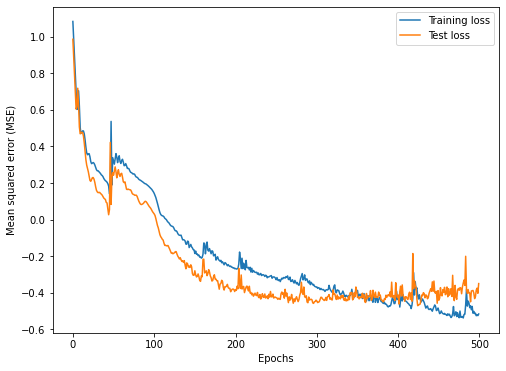

In [89]:
plt.figure(figsize=(8,6))
plt.plot(list(range(epochs)), training_losses, label="Training loss")
plt.plot(list(range(epochs)), test_losses, label="Test loss")
plt.xlabel("Epochs")
plt.ylabel("Mean squared error (MSE)")
plt.legend()
plt.show()

# Plotting sample predictions

Given the time series of avocado volumes sold, the LSTM predicts the average price over the time series.

<Figure size 864x432 with 0 Axes>

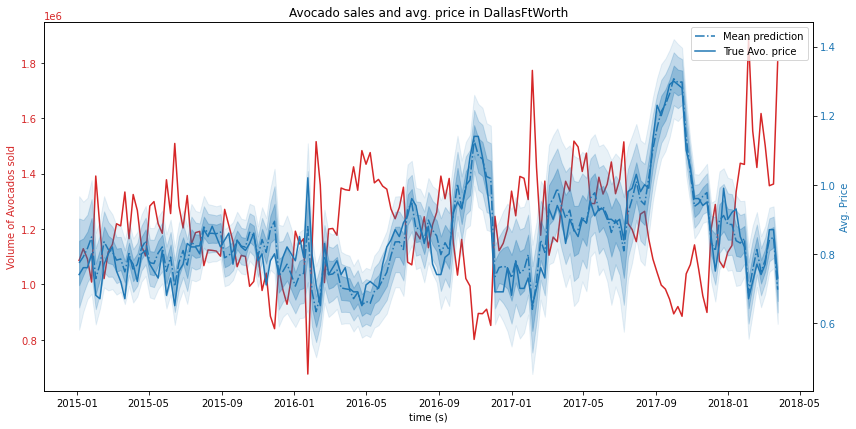

In [98]:
plt.figure(figsize=(12,6))

train = False  # Set to plot training data predictions

i = np.random.randint(0,18)

region_index = i + 18*train
region = unique_regions[region_index]
region_dict = region_stats[region]
c_mean, c_std = region_dict["mean_price"], region_dict["std_price"] 
v_mean, v_std = region_dict["mean_vol"], region_dict["std_vol"]

if train:
    x = x_test
    y = y_test
else:
    x = x_train
    y = y_train
    
with torch.no_grad():
    y_preds, y_log_vars = lstm_prediction(x, gaussian)
    y_stds = (0.5*y_log_vars).exp()
    
    
    

fig, ax1 = plt.subplots(figsize=(12,6))

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Volume of Avocados sold', color=color)
ax1.plot(time_stamps, x[:,i]*v_std + v_mean, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Avg. Price', color=color)  # we already handled the x-label with ax1
ax2.plot(time_stamps, y_preds[:, i]*c_std + c_mean, color=color, ls="-.", label="Mean prediction")
alphas = [0.3, 0.2, 0.1]

for k in range(3):
    j = k + 1
    lower_bound = (y_preds[:, i]-j*y_stds[:, i]).squeeze()*c_std + c_mean
    upper_bound = (y_preds[:, i]+j*y_stds[:, i]).squeeze()*c_std + c_mean
    ax2.fill_between(time_stamps, lower_bound, upper_bound, alpha=alphas[k], color=color)

ax2.plot(time_stamps, y[:, i]*c_std + c_mean, color=color, label="True Avo. price")
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.title(f"Avocado sales and avg. price in {region}")
plt.legend()
plt.show();
